In [55]:
#Calling all the libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

Loading the UCL Occupancy Detection Data Set. The Data Set includes columns like - date time, temperature, relatibe humidity, humidity ratio, light intensity, levels of CO2 and occupancy status.

In [56]:
#Loading the Data sets
df = pd.read_csv("./datatraining.txt", sep=",")
df_test = pd.read_csv("./datatest.txt", sep=",")

Below is the plot for CO2 levels in the room with the occupancy status. This shows that it correlates with the levels of CO2 in thr room.

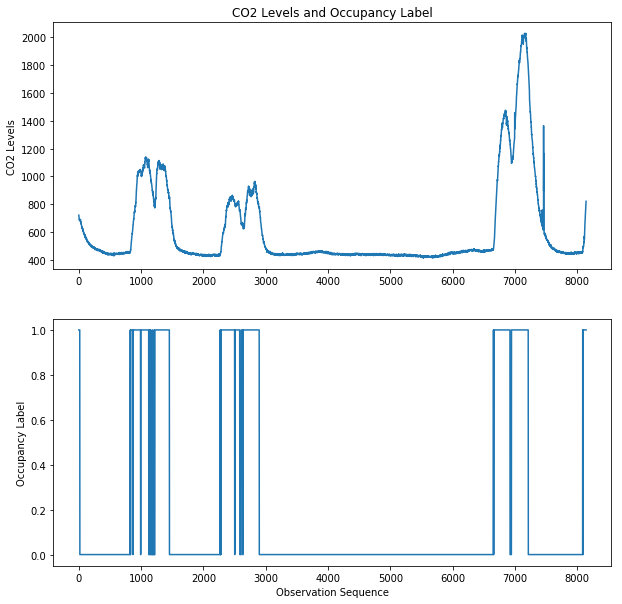

In [57]:
#Visualizing the sequence for CO2 levels
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
ax1.plot(df.CO2)
ax1.set_ylabel("CO2 Levels")
ax1.set_title("CO2 Levels and Occupancy Label")
ax2 = fig.add_subplot(212)
ax2.plot(df.Occupancy)
ax2.set_xlabel("Observation Sequence")
ax2.set_ylabel("Occupancy Label")
plt.show()

Below is the plot for levels of light intensity in the room with the occupancy status. This shows that it correlates with the levels of light intensity in thr room.

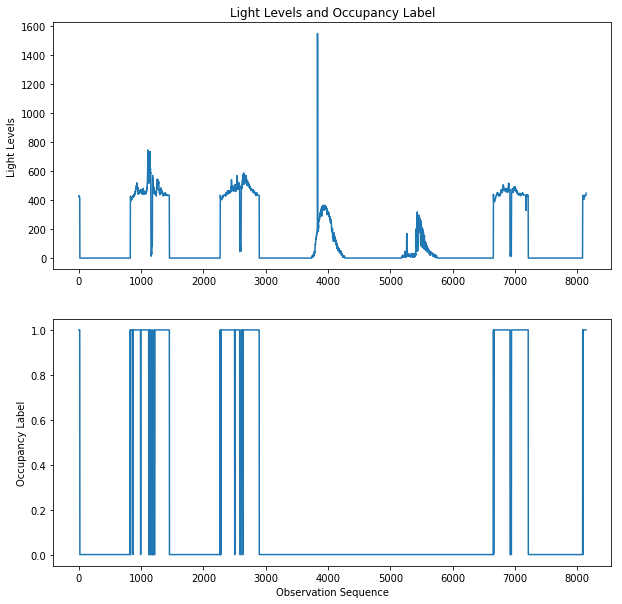

In [58]:
#Visualizing the sequence for Light levels
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
ax1.plot(df.Light)
ax1.set_ylabel("Light Levels")
ax1.set_title("Light Levels and Occupancy Label")
ax2 = fig.add_subplot(212)
ax2.plot(df.Occupancy)
ax2.set_xlabel("Observation Sequence")
ax2.set_ylabel("Occupancy Label")
plt.show()

In [59]:
#Reporting the mean, median and variance values
mean = sum(df.CO2.values)/len(df.CO2.values)
med = np.median([df.CO2])
variance = np.var([df.CO2])
print("Mean:",mean ,"\nMedian:",med,"\nVariance:",variance)

Mean: 606.546243195 
Median: 453.5 
Variance: 98785.4808159


In [60]:
#Reporting the mean, median and variance values
v1 = sum(df.Light.values)/len(df.Light.values)
v2 = np.median([df.Light])
v3 = np.var([df.Light])
print("Mean:",v1 ,"\nMedian:",v2,"\nVariance:",v3)

Mean: 119.519374514 
Median: 0.0 
Variance: 37925.165536


Below are the functions for implementing forward, backward, baum-welch and viterbi algorithm. 

In [61]:
#Function for forward algorithm
def forward(O,A,b,pi,itr):
    s=[]
    obs = len(pi)
    #first claculate alpha1
    a0 = [pi[i]*b[i][O[0]] for i in range(0,obs)]
    a0 = [k/sum(a0) for k in a0]
    s.append(a0)
    #Calculating beta2
    a1 = [sum([a0[i]*A[i][j] for i in range(0,obs) for j in range(0,len(pi))])*b[k][O[1]] for k in range(0,obs)] 
    a1 = [k/sum(a1) for k in a1]
    s.append(a1)
    #Running the process in a loop
    for t in range(2,(itr+1)):
        l = [sum([s[(t-1)][i]*A[i][j] for i in range(0,obs) for j in range(0,obs)])*b[k][O[t]] for k in range(0,obs)]
        l = [k/sum(l) for k in l]
        s.append(l)
    return(s)

#Function for backward algorithm
def backward(O,A,b,pi,itrs,itrst):
    s=[]
    obs = len(pi)
    #first calculate beta(T)
    bT=[1 for i in range(0,obs)]
    s.append(bT)
    #calculating beta(T-1)
    bT_1=[sum([A[i][j]*b[j][O[(itrs)]] for j in range(0,obs)]) for i in range(0,obs)]
    bT_1 = [k/sum(bT_1) for k in bT_1]
    s.append(bT_1)
    itrs = itrs -1
    t = 1
    while itrs > itrst:
        l= [sum([A[i][j]*b[j][O[(itrs)]]*s[t][j] for j in range(0,obs)]) for i in range(0,obs)]
        l = [k/sum(l) for k in l]
        s.append(l)
        itrs = itrs -1
        t = t+1
    return(s[::-1]) 


In [62]:

#Function for calculating Gamma
def gamma(a,b,t,i):
    g = (a[t][i]*b[t][i])/sum((np.array(a[t])*np.array(b[t])))
    return(g)

def kyi(A,B,t,i,j,a,b,o,obs):
    ky = (a[t][i]*A[i][j]*B[j][o[t+1]]*b[t+1][j])/sum([sum([a[t][k]*A[k][l]*B[l][o[t+1]]*b[t+1][l] for l in range(0,obs)]) for k in range(0,obs)])
    return(ky)

def check(o,m):
    if o == m:
        return(1)
    else:
        return(0)
#Function for Baum-Welch Algorithm

#It can have multiple observation sequences
def baumwelch(O,A,B,Pi,components,it):
    A_temp=A
    B_temp=B
    c=components
    HS = len(Pi)
    iterations = 0
    while iterations < it:
        #Calculating the forward and the backward
        f=[]
        b=[]
        #This would give the forward and backward for all times and 
        for o in O:
            s1=forward(o,A,B,Pi,(len(o)-1))
            s2=backward(o,A,B,Pi,(len(o)-1),0)
            f.append(s1)
            b.append(s2)
        #Calculating the parameters

        for i in range(0,HS):
            for j in range(0,HS):
                A_temp[i][j]=([sum([kyi(A,B,t,i,j,f[k],b[k],O[k],HS)
                                        for t in range(0,(len(O[k])-1))]) for k in range(0,len(O))])/sum([sum([gamma(f[k],b[k],t,i)for t in range(0,(len(O[k])-1))]) for k in range(0,len(O))])


        for j in range(0,HS):
            for m in range(0,c):
                B_temp[j][m]= sum([sum(np.array([gamma(f[k],b[k],t,j) for t in range(0,len(O[k]))])*np.array([check(o,m)  for o in O[k]]))
                                    for k in range(0,len(O))])/sum([sum([gamma(f[k],b[k],t,j) for t in range(0,len(O[k]))]) for k in range(0,len(O))])


        for i in range(0,HS):    
            Pi[i] = sum([gamma(f[k],b[k],0,i) for k in range(0,len(O))])/len(O)

        A = A_temp
        B = B_temp
        
        iterations = iterations+1
    return(A,B,Pi)
    


def viterbi(O,A,B,Pi):
    obs = len(Pi)
    D = []
    P = []
    #Initiation
    d = [Pi[i]*B[i][O[0]] for i in range(0,obs)]
    p = 0
    D.append(d)
    P.append([p])
    #Recurrence
    for t in range(1,len(O)):
        d = [max(np.array([D[t-1][i]*A[i][j]*B[j][O[t]] for i in range(0,obs)])) for j in range(0,obs)]
        p = [np.argmax(np.array([D[t-1][i]*A[i][j] for i in range(0,obs)])) for j in range(0,obs)]
        D.append(d)
        P.append(p)
    #Termination
    Q=[]
    p = max(np.array(D[len(O)-1]))
    q = np.argmax(np.array(D[len(O)-1]))
    Q.extend([q])
    #BackTracking
    t = len(O)-2
    s= t
    while t >= 0:
        q=P[t+1][Q[(s-t)]]
        Q.extend([q])
        t = t-1
    return(Q[::-1])

Creating classes for CO2 levels in the room.

In [89]:
df = pd.read_csv("./datatraining.txt", sep=",")
#Generating the labels for CO2 levels
#Loading the Data set
def gl_CO2(x):
    if x <= 500:
        return(0)
    if (x>500)and(x<=1000):
        return(1)
    if x>1000:
        return(2)
        
df['CO2'] = df['CO2'].apply(lambda x : gl_CO2(int(x)))

We are using HMM to predict the occupancy status of the room. We are using occupancy status as the hidden status of the HMM and the CO2 labels or the light intensity labels as the observable states of the HMM. We use baum welch to train on observable states and use viterbi algorithm to predict the hidden states.

In [84]:
#Defining the parameters for the Hidden Markov //model
Hidden_states = 2
output = 3
startprob = [1/2,1/2]
transmat = np.random.randint(1, size=(Hidden_states,Hidden_states))
for i in range(0,Hidden_states):
    for j in range(i-1,i+2):
        if (j<=(Hidden_states-1))&(j>=0):
            transmat[i][j] = np.random.randint(low=1, high = 2000)
transmat = transmat/transmat.sum(axis=1, keepdims=True)
emissionprob = np.random.randint(low=1, high = 2000, size=(Hidden_states,output))
emissionprob = emissionprob/emissionprob.sum(axis=1, keepdims=True)

In [85]:
O = [df.CO2.tolist()]
A,B,Pi = baumwelch(O,transmat,emissionprob,startprob,3,20)

In [90]:
df_test = pd.read_csv("./datatest.txt", sep=",")
df_test['CO2'] = df_test['CO2'].apply(lambda x : gl_CO2(int(x)))
df_test['CO2'].values
C02_pred = viterbi(df_test['CO2'].values,A,B,Pi)

Calculating the accuracy using only the CO2 levels.

In [103]:
accuracy1 = accuracy_score(df_test.Occupancy.values, C02_pred)
accuracy1*100

82.926829268292678

Plotting the predicted occupancy status to the actual occupancy status. 

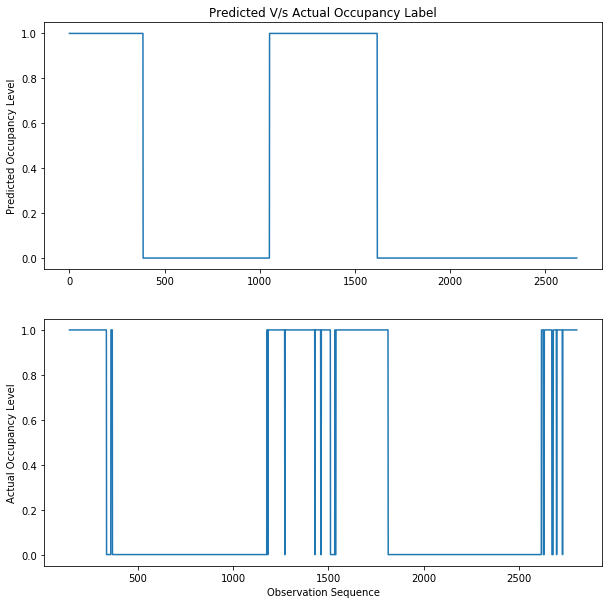

In [104]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(211)
ax1.plot(C02_pred)
ax1.set_ylabel("Predicted Occupancy Level")
ax1.set_title("Predicted V/s Actual Occupancy Label")
ax2 = fig.add_subplot(212)
ax2.plot(df_test.Occupancy)
ax2.set_ylabel("Actual Occupancy Level")
ax2.set_xlabel("Observation Sequence")

plt.show()

Creating class labels for the level of light in the room.

In [123]:
df = pd.read_csv("./datatraining.txt", sep=",")
df_test = pd.read_csv("./datatest.txt", sep=",")
def gl_light(x):
    if x <= 10:
        return(0)
    if (x>10)and(x<=200):
        return(1)
    if x>200:
        return(2)
        
df['Light'] = df['Light'].apply(lambda x : gl_light(int(x)))
df_test['Light'] = df_test['Light'].apply(lambda x : gl_light(int(x)))


Running HMM in a similar way as done above but this time with the class labels for light intensity.

In [124]:
Hidden_states = 2
output = 3
startprob = [1/2,1/2]
transmat = np.random.randint(1, size=(Hidden_states,Hidden_states))
for i in range(0,Hidden_states):
    for j in range(i-1,i+2):
        if (j<=(Hidden_states-1))&(j>=0):
            transmat[i][j] = np.random.randint(low=1, high = 2000)
transmat = transmat/transmat.sum(axis=1, keepdims=True)
emissionprob = np.random.randint(low=1, high = 2000, size=(Hidden_states,output))
emissionprob = emissionprob/emissionprob.sum(axis=1, keepdims=True)

In [125]:
O = [df.Light.tolist()]
A,B,Pi = baumwelch(O,transmat,emissionprob,startprob,3,15)

In [126]:
df_test['Light'].values
Light_pred = viterbi(df_test['Light'].values,A,B,Pi)

In [127]:
accuracy2 = accuracy_score(df_test.Occupancy.values, Light_pred)
accuracy2*100

97.073170731707307

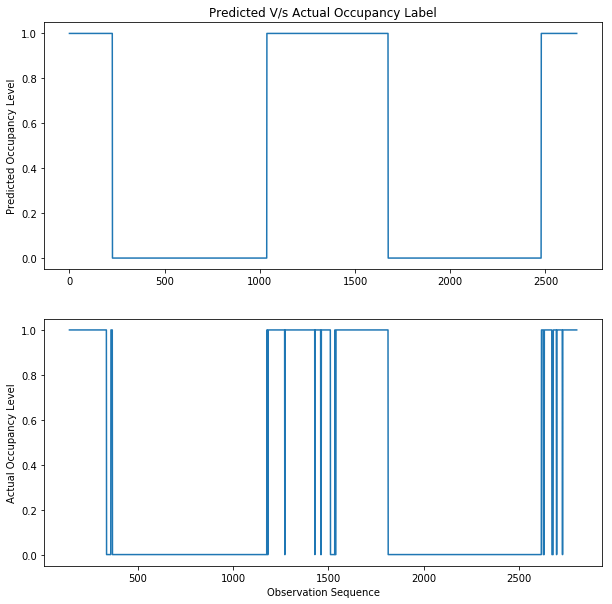

In [128]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(211)
ax1.plot(Light_pred)
ax1.set_ylabel("Predicted Occupancy Level")
ax1.set_title("Predicted V/s Actual Occupancy Label")
ax2 = fig.add_subplot(212)
ax2.plot(df_test.Occupancy)
ax2.set_ylabel("Actual Occupancy Level")
ax2.set_xlabel("Observation Sequence")

plt.show()